# Compare censored and uncensored 6-month interval frequencies

Frequencies used by the fitness model need to be estimated at 6-month intervals (timepoints).
Instead of estimating frequencies at 1-month intervals and then interpolating frequencies at fitness model timepoints, we just estimate frequencies at the same 6-month intervals needed by the fitness model.
We also pre-censor frequencies such that they only need to be calculated once.

Here, we compare these censored frequencies at 6-month intervals with the observed uncensored frequencies for the same intervals to get a sense of how much uncertainty in frequency estimates there is at any given timepoint.

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys

%matplotlib inline

In [2]:
os.getcwd()

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
project_path = os.path.dirname(os.getcwd())
augur_path = os.path.join(project_path, "dist", "augur")

In [4]:
augur_path

'/Users/jlhudd/projects/nextstrain/flu-forecasting/dist/augur'

In [5]:
sys.path.append(augur_path)

In [7]:
from base.frequencies import KdeFrequencies
from base.io_util import json_to_tree

In [9]:
with open("flu_h3n2_ha_2006-2018y_92v_0_tree.json", "r") as fh:
    json_tree = json.load(fh)

tree = json_to_tree(json_tree)

First, calculate uncensored frequencies for the given tree.

In [85]:
kde_frequencies = KdeFrequencies(
    start_date=2006.75,
    end_date=2018.25,
    censored=False,
    pivot_frequency=6,
    sigma_narrow=0.25,
    proportion_wide=0.0
)
uncensored_frequencies = kde_frequencies.estimate(tree)

Then, calculated censored frequencies for comparison with the uncensored.

In [86]:
params = kde_frequencies.get_params()
params["censored"] = True
kde_frequencies = KdeFrequencies(**params)
censored_frequencies = kde_frequencies.estimate(tree)

In [87]:
kde_frequencies.get_params()

{'censored': True,
 'end_date': 2018.25,
 'include_internal_nodes': False,
 'max_date': None,
 'pivot_frequency': 6,
 'proportion_wide': 0.0,
 'sigma_narrow': 0.25,
 'sigma_wide': 0.25,
 'start_date': 2006.75,
 'weights': None,
 'weights_attribute': None}

Combine frequencies into a data frame by tip for all pivots where both uncensored and censored frequencies are non-zero.

In [88]:
records = []
for strain in uncensored_frequencies.keys():
    for i in range(len(kde_frequencies.pivots)):
        if censored_frequencies[strain][i] > 0 and uncensored_frequencies[strain][i] > 0:
            records.append({
                "strain": strain,
                "pivot": kde_frequencies.pivots[i],
                "observed_frequency": uncensored_frequencies[strain][i],
                "censored_frequency": censored_frequencies[strain][i]
            })
        
df = pd.DataFrame(records)

Fit a linear regression to the censored and uncensored frequencies for each tip in the tree, calculate summary statistics (intercept, slope, and Pearson's R), and plot the resulting regression.

In [89]:
df.shape

(105229, 4)

In [90]:
df["observed_frequency"].max()

0.003701583403620365

In [91]:
kde_frequencies.pivots

array([2006.75, 2007.25, 2007.75, 2008.25, 2008.75, 2009.25, 2009.75,
       2010.25, 2010.75, 2011.25, 2011.75, 2012.25, 2012.75, 2013.25,
       2013.75, 2014.25, 2014.75, 2015.25, 2015.75, 2016.25, 2016.75,
       2017.25, 2017.75, 2018.25])

In [92]:
df.loc[np.argwhere(df["observed_frequency"] == df["observed_frequency"].max())[0][0], :]

censored_frequency               0.0116214
observed_frequency              0.00370158
pivot                              2010.25
strain                A/HongKong/1837/2010
Name: 65394, dtype: object

In [93]:
df.head()

,censored_frequency,observed_frequency,pivot,strain
0,1.734757e-03,8.855892e-04,2012.25,A/Fukuoka-C/69/2011
1,3.507403e-05,1.572947e-05,2012.75,A/Fukuoka-C/69/2011
2,8.750700e-09,5.103456e-09,2013.25,A/Fukuoka-C/69/2011
3,7.703329e-14,2.969530e-14,2013.75,A/Fukuoka-C/69/2011
4,4.927410e-21,2.492596e-21,2014.25,A/Fukuoka-C/69/2011


In [94]:
y = df["censored_frequency"]
x = df["observed_frequency"]
x = sm.add_constant(x)
ols = sm.OLS(y, x)
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     censored_frequency   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.308e+06
Date:                Sun, 18 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:14:30   Log-Likelihood:             7.4340e+05
No. Observations:              105229   AIC:                        -1.487e+06
Df Residuals:                  105227   BIC:                        -1.487e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.263e-06   6.64e-07      7.922      0.000    3.96e-06    6.57e-06
observed_frequency     1.8810      0.002   1143.507      0.000       1.878       1.884
==============================================================================
Omnibus:                    85842.515   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         94023118.826
Skew:                           2.644   Prob(JB):                         0.00
Kurtosis:                     149.343   Cond. No.                     2.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

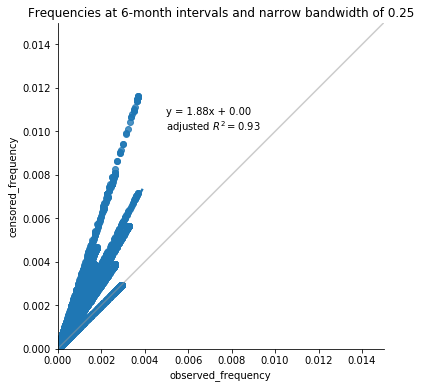

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

min_freq = -0.00
max_freq = 0.015
x = np.linspace(0, max_freq, 100)
y = x
sns.regplot("observed_frequency", "censored_frequency", df, ax=ax)
ax.plot(x, y, color="#999999", alpha=0.5)
ax.set_aspect("equal")
ax.set_xlim(min_freq, max_freq)
ax.set_ylim(min_freq, max_freq)
ax.text(0.005, 0.01, "y = %.2fx + %.2f\nadjusted $R^{2} = %.2f$" % (
    results.params["observed_frequency"],
    results.params["const"],
    results.rsquared_adj
))
ax.set_title("Frequencies at 6-month intervals and narrow bandwidth of %.2f" % kde_frequencies.sigma_narrow)
sns.despine()